In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_datareader.famafrench as ff
import datetime
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import models
import tensorflow as tf

In [2]:
# for a prettier notebook
np.set_printoptions(linewidth=160)
pd.set_option('display.max_columns', None)

In [3]:
# selects dates for Yahoo Finance
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = pd.read_csv("DJIA+OLD.csv", header=None) # components as of 2021-03-09
tickers = list(tickers[0])
#for ticker in tickers:
#    print(ticker)

In [4]:
#ff.get_available_datasets()

In [5]:
# loads FF5 from French
ff_dict = web.DataReader('North_America_5_Factors_Daily', "famafrench", start, end)
print(ff_dict.pop("DESCR"))
ff_dict = ff_dict[0]

North America 5 Factors Daily
-----------------------------

This file was created using the 202101 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6002 rows x 6 cols)


In [6]:
factors = pd.DataFrame(ff_dict)
factors.index = pd.to_datetime(factors.index.to_timestamp())
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1998-01-01,-0.02,0.00,0.00,0.00,0.00,0.02
1998-01-02,0.23,-0.08,-0.54,0.15,-0.19,0.02
1998-01-05,0.24,-0.03,-0.39,0.11,0.01,0.02
1998-01-06,-1.09,0.25,0.01,-0.21,0.09,0.02
1998-01-07,-0.37,-0.27,-0.19,0.22,0.35,0.02
...,...,...,...,...,...,...
2020-12-28,0.50,-0.86,0.34,1.05,0.39,0.00
2020-12-29,-0.36,-1.17,0.29,0.54,0.12,0.00
2020-12-30,0.30,1.00,0.37,-0.49,0.22,0.00


In [7]:
# loads MOM from French
mom_dict = web.DataReader('North_America_MOM_Factor_Daily', "famafrench", start, end)
print(mom_dict.pop("DESCR"))
mom_dict = mom_dict[0]
mom_factors = pd.DataFrame(mom_dict)
mom_factors.index = pd.to_datetime(mom_factors.index.to_timestamp())
mom_factors

North America MOM Factor Daily
------------------------------

This file was created using the 202101 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6002 rows x 1 cols)


,WML
Date,
1998-01-01,0.00
1998-01-02,-1.16
1998-01-05,0.14
1998-01-06,0.07
1998-01-07,-0.45
...,...
2020-12-28,-0.76
2020-12-29,-0.41
2020-12-30,-0.01


In [8]:
# Reads compustat data from the .csv
COMPUSTAT = pd.read_csv("cgzl2kcmdzauvfas.csv")
COMPUSTAT.dropna(thresh=COMPUSTAT.shape[0]*0.99,how='all',axis=1, inplace=True) # REMOVE FEATURE IF NaN > 1%
COMPUSTAT=COMPUSTAT[COMPUSTAT.isna().sum().sort_values().keys()]
COMPUSTAT.set_index(pd.to_datetime(COMPUSTAT["public_date"], format="%Y%m%d"), inplace=True) # TODO IS THIS CORRECT?
COMPUSTAT = COMPUSTAT.drop(columns = ["gvkey", "permno", "qdate", "adate", "public_date", "cusip"])
COMPUSTAT[COMPUSTAT["TICKER"]=="MMM"]

,rd_sale,ps,npm,ptpm,GProf,opmbd,opmad,gpm,TICKER,debt_assets,de_ratio,staff_sale,adv_sale,aftret_eq,aftret_equity,equity_invcap,sale_invcap,at_turn,pcf,accrual,roa,cash_lt,capital_ratio,lt_debt,debt_invcap,cash_debt,debt_at
public_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-31,0.000,3.398,0.112,0.231,0.604,0.269,0.230,0.500,MMM,0.251,0.338,0.279,0.000,0.197,0.197,0.977,1.592,1.279,31.044,0.014,0.344,0.364,0.013,0.040,0.013,0.604,0.030
1970-02-28,0.048,3.686,0.111,0.227,0.601,0.260,0.220,0.501,MMM,0.263,0.360,0.281,0.000,0.194,0.194,0.972,1.594,1.287,37.377,-0.016,0.334,0.292,0.022,0.063,0.022,0.449,0.047
1970-03-31,0.048,3.534,0.111,0.227,0.601,0.260,0.220,0.501,MMM,0.263,0.360,0.281,0.000,0.194,0.194,0.972,1.594,1.287,35.834,-0.016,0.334,0.292,0.022,0.063,0.022,0.449,0.047
1970-04-30,0.048,3.171,0.111,0.227,0.601,0.260,0.220,0.501,MMM,0.263,0.360,0.281,0.000,0.194,0.194,0.972,1.594,1.287,32.148,-0.016,0.334,0.292,0.022,0.063,0.022,0.449,0.047
1970-05-31,0.000,2.808,0.111,0.223,0.601,0.260,0.220,0.501,MMM,0.263,0.360,0.281,0.000,0.185,0.185,0.978,1.631,1.287,28.976,-0.016,0.334,0.292,0.022,0.063,0.022,0.449,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.061,2.995,0.164,0.203,0.379,0.270,0.214,0.539,MMM,0.765,3.268,0.000,0.011,0.501,0.501,0.353,1.061,0.703,12.557,0.054,0.197,0.144,0.646,0.558,0.644,0.205,0.485
2020-09-30,0.061,2.943,0.164,0.203,0.379,0.270,0.214,0.539,MMM,0.765,3.268,0.000,0.011,0.501,0.501,0.353,1.061,0.703,12.338,0.054,0.197,0.144,0.646,0.558,0.644,0.205,0.485
2020-10-31,0.061,2.943,0.164,0.203,0.379,0.270,0.214,0.539,MMM,0.765,3.268,0.000,0.011,0.501,0.501,0.353,1.061,0.703,12.339,0.054,0.197,0.144,0.646,0.558,0.644,0.205,0.485


In [9]:
# Removes WX due to it not existing anymore
tickers.remove("WX")
tickers

['MMM',
 'AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'CRM',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'NAV',
 'X',
 'Z',
 'GT',
 'T',
 'KODK',
 'IP',
 'MO',
 'AIG',
 'C',
 'MDLZ',
 'AA',
 'BAC',
 'HPQ',
 'HPE',
 'GE',
 'RTX',
 'XOM',
 'PFE']

In [10]:
# Loads data from Yahoo Finance
DJIA_raw = web.DataReader(tickers[:], 'yahoo', start, end) # ticker input must be a list!
DJIA_raw

Attributes   Adj Close                                                  \
Symbols            MMM         AXP        AMGN        AAPL          BA   
Date                                                                     
1998-01-02   23.195230   19.040146   10.670461    0.124974   30.740919   
1998-01-05   23.160500   19.080399   10.633366    0.122091   30.583677   
1998-01-06   23.229958   18.691282   10.509720    0.145644   30.111950   
1998-01-07   23.420925   18.516855   10.522089    0.134588   30.269196   
1998-01-08   23.143145   18.141138   10.559179    0.139875   29.168503   
...                ...         ...         ...         ...         ...   
2020-12-24  173.093628  116.939957  221.284622  131.773087  217.149994   
2020-12-28  173.282074  117.946426  221.999313  136.486053  216.089996   
2020-12-29  172.429108  117.727196  225.195541  134.668762  216.250000   
2020-12-30  172.686966  119.012688  225.493332  133.520477  216.669998   
2020-12-31  173.361404  120.487518  228.223038  132.492020  214.059998   

Attributes                                                          \
Symbols            CAT        CVX       CSCO         KO        DOW   
Date                                                                 
1998-01-02   13.254756  17.031889   7.236827  18.289318        NaN   
1998-01-05   13.440728  16.540184   7.221252  18.152699        NaN   
1998-01-06   13.339283  16.116776   7.127772  18.067314        NaN   
1998-01-07   13.102592  16.690437   6.917445  18.084387        NaN   
1998-01-08   12.663025  16.062149   6.995344  18.203930        NaN   
...                ...        ...        ...        ...        ...   
2020-12-24  178.609695  84.140633  44.181690  52.998867  54.187817   
2020-12-28  177.425995  83.716629  44.558628  53.712925  53.693314   
2020-12-29  175.715103  83.430672  44.280884  53.683174  53.732876   
2020-12-30  179.087158  84.140633  44.122169  53.990612  54.860344   
2020-12-31  181.056686  83.272896  44.389999  54.387314  54.890015   

Attributes                                                             \
Symbols             GS          HD         HON         IBM       INTC   
Date                                                                    
1998-01-02         NaN   12.662699   22.552612   32.795517  11.302661   
1998-01-05         NaN   12.486830   22.267132   33.047802  11.594467   
1998-01-06         NaN   12.568009   22.374182   32.679089  11.380476   
1998-01-07         NaN   12.703284   22.267132   32.368587  11.322114   
1998-01-08         NaN   12.649177   21.981657   32.349190  11.565288   
...                ...         ...         ...         ...        ...   
2020-12-24  255.157745  269.232880  208.606613  123.045761  46.786011   
2020-12-28  258.574310  267.573273  209.014816  123.174042  46.786011   
2020-12-29  257.000519  264.532349  208.208389  122.167496  49.092014   
2020-12-30  258.434875  263.608124  210.020355  122.700371  48.455875   
2020-12-31  262.678192  263.965881  211.762650  124.220062  49.519421   

Attributes                                                             \
Symbols            JNJ         JPM         MCD        MRK        MSFT   
Date                                                                    
1998-01-02   18.463949   18.983402   13.943696  23.688675   10.410520   
1998-01-05   18.446209   19.294432   13.907093  23.826250   10.350970   
1998-01-06   18.162428   18.393530   13.943696  23.496096   10.410520   
1998-01-07   18.339787   18.597303   13.833900  23.138420   10.286464   
1998-01-08   18.552624   17.878723   13.577722  23.372290   10.360898   
...                ...         ...         ...        ...         ...   
2020-12-24  151.525131  123.629646  210.097305  79.442009  222.238144   
2020-12-28  152.240677  124.443787  212.711227  79.749306  224.443069   
2020-12-29  153.184784  124.116150  211.409241  80.710861  223.634918   
2020-12-30  155.082947  124.463646  210.266266  79.888092  221.170593   
2020-12-31

In [11]:
# Select features
DJIA = DJIA_raw.copy()
DJIA = DJIA[["Adj Close", "Volume"]]

In [12]:
# Convert into returns
DJIA["Adj Close"] = DJIA["Adj Close"]/DJIA["Adj Close"].shift(1)
DJIA["Adj Close"] = DJIA["Adj Close"] - 1

In [13]:
# Scale volume so that first volume for that stock is 1
for column in DJIA["Volume"]:
    DJIA["Volume", column] = DJIA["Volume", column] / DJIA["Volume", column].loc[DJIA["Volume", column].first_valid_index()]

In [14]:
# Convert to rolling sum of last 7 trading days
DJIA["Volume"] = DJIA["Volume"].rolling(7).sum()

In [15]:
# Shift to get rid of NaN
DJIA = DJIA.iloc[6:]

In [16]:
# Actually not used anymore
DJIA["MEAN"] = DJIA["Adj Close"].mean(axis=1)
DJIA

Attributes Adj Close                                                    \
Symbols          MMM       AXP      AMGN      AAPL        BA       CAT   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Attributes                                                              \
Symbols          CVX      CSCO        KO       DOW        GS        HD   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214       NaN       NaN  0.031042   
1998-01-13  0.017903  0.005612 -0.010406       NaN       NaN  0.017205   
1998-01-14  0.011725  0.017857 -0.011473       NaN       NaN  0.009514   
1998-01-15  0.007450  0.007676 -0.013539       NaN       NaN -0.006283   
1998-01-16  0.009038  0.007617  0.019608       NaN       NaN  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Attributes                                                              \
Symbols          HON       IBM      INTC       JNJ       JPM       MCD   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Attributes                                                              \
Symbols          MRK      MSFT       NKE        PG       CRM       TRV   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582       NaN  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427       NaN  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934       NaN -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758       NaN  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818       NaN  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [17]:
# Converting factors to multiindex for joining later
factors = pd.concat([factors], keys=['MACRO'], axis=1)
mom_factors = pd.concat([mom_factors], keys=['MACRO'], axis=1)

In [18]:
# Putting the ticker as the first level instead of feature since we want to be able to select stocks 
DJIA.columns = DJIA.columns.swaplevel(0, 1)
DJIA

Symbols,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS,NAV,X,Z,GT,T,KODK,IP,MO,AIG,C,MDLZ,AA,BAC,HPQ,HPE,GE,RTX,XOM,PFE,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS,NAV,X,Z,GT,T,KODK,IP,MO,AIG,C,MDLZ,AA,BAC,HPQ,HPE,GE,RTX,XOM,PFE,
Attributes,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,MEAN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-12,0.002269,-0.003049,0.005938,0.003436,0.005540,0.022009,0.030756,0.026497,0.030214,NaN,NaN,0.031042,-0.025210,0.000625,0.052174,0.020310,0.007362,0.022039,0.032199,0.019685,0.011076,0.043582,NaN,0.024773,-0.017676,0.018050,NaN,0.035270,0.034369,-0.016276,0.012821,0.061136,NaN,0.007503,0.014847,NaN,-0.017570,0.030555,-0.019382,-0.009173,NaN,-0.001209,-0.015890,0.003024,NaN,0.027610,0.017335,0.010753,0.033813,9.197590,9.037432,11.601115,8.913736,10.634375,12.457398,10.170651,11.212117,8.801146,NaN,NaN,8.954002,10.815496,12.587742,12.473289,8.469633,21.150633,9.287277,8.820043,12.403140,10.257742,9.280339,NaN,20.793443,13.543268,7.024380,NaN,8.391171,11.842238,12.826648,12.805028,10.639962,NaN,6.870130,6.943849,NaN,8.352020,9.859653,11.997387,14.071129,NaN,11.646333,18.409664,8.704868,NaN,10.391767,12.230475,10.223962,14.867447,0.013980
1998-01-13,0.015850,0.012997,-0.018890,0.068495,-0.006886,-0.008076,0.017903,0.005612,-0.010406,NaN,NaN,0.017205,0.013794,0.019975,0.017355,0.006634,0.009744,0.016172,0.000588,0.020270,0.025040,-0.014427,NaN,0.008864,-0.012854,0.013475,NaN,0.002004,0.000000,0.005956,0.005063,-0.020577,NaN,0.028723,0.009467,NaN,0.016393,0.032346,-0.001853,0.050264,NaN,-0.001211,0.000000,0.027136,NaN,0.003359,0.017937,0.022341,0.011448,8.834979,8.978229,13.014830,8.800583,10.982544,14.247732,10.210113,11.667278,8.976925,NaN,NaN,9.383114,11.231385,12.883567,13.851854,8.821450,22.564770,9.519382,9.180307,13.087391,9.962624,9.684173,NaN,22.454098,14.620737,6.756703,NaN,9.805862,12.492970,13.536464,13.082771,13.506676,NaN,6.658920,6.549138,NaN,9.154391,10.519582,13.397213,14.952892,NaN,12.241375,21.707883,8.724508,NaN,10.891342,12.880918,10.800184,15.786439,0.010420
1998-01-14,-0.000744,0.006792,-0.037305,0.012820,0.026352,0.006784,0.011725,0.017857,-0.011473,NaN,NaN,0.009514,0.030612,0.004896,-0.019496,0.001884,0.007238,-0.001326,0.034118,-0.007568,0.006106,-0.006934,NaN,-0.003994,0.018229,0.000000,NaN,0.030000,0.004747,0.015789,0.020151,0.004201,NaN,0.018614,0.004263,NaN,0.007332,-0.018277,-0.003713,0.012595,NaN,0.001818,0.047363,-0.013699,NaN,-0.004184,0.020264,0.012487,0.006467,8.566498,8.685993,15.203835,8.713399,10.831275,14.907658,9.530198,11.234028,8.606114,NaN,NaN,9.224400,10.848166,12.602125,14.965871,8.752470,23.507665,8.824574,10.096890,12.443252,9.025853,9.340888,NaN,23.113115,14.317366,6.312705,NaN,9.902117,13.075022,10.681505,12.755978,14.316881,NaN,6.504215,5.750550,NaN,9.002191,10.359920,14.063589,14.873601,NaN,12.735435,22.292443,8.277869,NaN,10.317535,12.716725,10.384183,14.498212,0.006642
1998-01-15,-0.018587,-0.023988,-0.020000,-0.028479,-0.045946,-0.013550,0.007450,0.007676,-0.013539,NaN,

In [19]:
# Merge stocks with factors
#DJIA.columns = DJIA.columns.get_level_values(0)
DJIA = DJIA.join(factors)
DJIA = DJIA.join(mom_factors)
DJIA

Symbols          MMM       AXP      AMGN      AAPL        BA       CAT  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Symbols          CVX      CSCO        KO       DOW        GS        HD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214       NaN       NaN  0.031042   
1998-01-13  0.017903  0.005612 -0.010406       NaN       NaN  0.017205   
1998-01-14  0.011725  0.017857 -0.011473       NaN       NaN  0.009514   
1998-01-15  0.007450  0.007676 -0.013539       NaN       NaN -0.006283   
1998-01-16  0.009038  0.007617  0.019608       NaN       NaN  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Symbols          HON       IBM      INTC       JNJ       JPM       MCD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Symbols          MRK      MSFT       NKE        PG       CRM       TRV  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582       NaN  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427       NaN  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934       NaN -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758       NaN  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818       NaN  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [20]:
DJIA.replace(-99.99, np.nan, inplace=True) # For FF
print(DJIA.isna().sum())
DJIA.fillna(0, inplace=True)
print(DJIA.isna().sum())
DJIA

Symbols  Attributes
MMM      Adj Close     0
AXP      Adj Close     0
AMGN     Adj Close     0
AAPL     Adj Close     0
BA       Adj Close     0
                      ..
MACRO    HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
Length: 106, dtype: int64
Symbols  Attributes
MMM      Adj Close     0
AXP      Adj Close     0
AMGN     Adj Close     0
AAPL     Adj Close     0
BA       Adj Close     0
                      ..
MACRO    HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
Length: 106, dtype: int64


Symbols          MMM       AXP      AMGN      AAPL        BA       CAT  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Symbols          CVX      CSCO        KO       DOW        GS        HD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214  0.000000  0.000000  0.031042   
1998-01-13  0.017903  0.005612 -0.010406  0.000000  0.000000  0.017205   
1998-01-14  0.011725  0.017857 -0.011473  0.000000  0.000000  0.009514   
1998-01-15  0.007450  0.007676 -0.013539  0.000000  0.000000 -0.006283   
1998-01-16  0.009038  0.007617  0.019608  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Symbols          HON       IBM      INTC       JNJ       JPM       MCD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Symbols          MRK      MSFT       NKE        PG       CRM       TRV  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582  0.000000  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427  0.000000  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934  0.000000 -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758  0.000000  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818  0.000000  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [21]:
# joins with compustat
stocks = []
for ticker in tickers[:]:
    stock = DJIA[[ticker, "MACRO"]]
    stock.columns = stock.columns.get_level_values(-1)
    stock = stock.join(COMPUSTAT[COMPUSTAT["TICKER"]==ticker]).fillna(method='ffill')
    stock = stock.drop(columns=["TICKER"])
    stock = stock.fillna(0)
    stocks.append(stock.iloc[60:]) # the first tend to be NaN

In [22]:
stocks[0].isna().sum()

Adj Close        0
Volume           0
Mkt-RF           0
SMB              0
HML              0
RMW              0
CMA              0
RF               0
WML              0
rd_sale          0
ps               0
npm              0
ptpm             0
GProf            0
opmbd            0
opmad            0
gpm              0
debt_assets      0
de_ratio         0
staff_sale       0
adv_sale         0
aftret_eq        0
aftret_equity    0
equity_invcap    0
sale_invcap      0
at_turn          0
pcf              0
accrual          0
roa              0
cash_lt          0
capital_ratio    0
lt_debt          0
debt_invcap      0
cash_debt        0
debt_at          0
dtype: int64

In [23]:
stocks[3]

,Adj Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,rd_sale,ps,npm,ptpm,GProf,opmbd,opmad,gpm,debt_assets,de_ratio,staff_sale,adv_sale,aftret_eq,aftret_equity,equity_invcap,sale_invcap,at_turn,pcf,accrual,roa,cash_lt,capital_ratio,lt_debt,debt_invcap,cash_debt,debt_at
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-04-08,-0.019611,2.390505,-0.47,0.66,-0.17,-0.46,-0.17,0.02,0.15,0.064,0.560,-0.134,-0.134,0.336,-0.018,-0.037,0.221,0.716,2.520,0.0,0.02,-0.647,-0.629,0.527,3.006,1.520,15.437,0.248,-0.026,0.469,0.438,0.309,0.438,0.062,0.239
1998-04-09,0.025003,2.256001,0.79,0.18,-0.07,-0.07,-0.09,0.02,0.19,0.064,0.560,-0.134,-0.134,0.336,-0.018,-0.037,0.221,0.716,2.520,0.0,0.02,-0.647,-0.629,0.527,3.006,1.520,15.437,0.248,-0.026,0.469,0.438,0.309,0.438,0.062,0.239
1998-04-13,0.031705,2.397227,-0.05,-0.14,0.82,-0.02,-0.13,0.02,0.15,0.064,0.560,-0.134,-0.134,0.336,-0.018,-0.037,0.221,0.716,2.520,0.0,0.02,-0.647,-0.629,0.527,3.006,1.520,15.437,0.248,-0.026,0.469,0.438,0.309,0.438,0.062,0.239
1998-04-14,0.018911,2.583184,0.71,0.11,0.28,-0.43,-0.25,0.02,0.36,0.064,0.560,-0.134,-0.134,0.336,-0.018,-0.037,0.221,0.716,2.520,0.0,0.02,-0.647,-0.629,0.527,3.006,1.520,15.437,0.248,-0.026,0.469,0.438,0.309,0.438,0.062,0.239
1998-04-15,0.018565,3.076766,0.40,0.10,-0.11,-0.34,-0.29,0.02,-0.22,0.064,0.560,-0.134,-0.134,0.336,-0.018,-0.037,0.221,0.716,2.520,0.0,0.02,-0.647,-0.629,0.527,3.006,1.520,15.437,0.248,-0.026,0.469,0.438,0.309,0.438,0.062,0.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.007712,1.139686,0.24,-0.41,-0.33,0.24,0.09,0.00,0.10,0.068,7.373,0.209,0.244,0.358,0.282,0.241,0.423,0.798,3.957,0.0,0.00,0.737,0.737,0.379,1.592,0.829,25.089,0.070,0.234,0.352,0.621,0.414,0.621,0.312,0.378
2020-12-28,0.035766,1.176278,0.50,-0.86,0.34,1.05,0.39,0.00,-0.76,0.068,7.373,0.209,0.244,0.358,0.282,0.241,0.423,0.798,3.957,0.0,0.00,0.737,0.737,0.379,1.592,0.829,25.089,0.070,0.234,0.352,0.621,0.414,0.621,0.312,0.378
2020-12-29,-0.013315,1.213442,-0.36,-1.17,0.29,0.54,0.12,0.00,-0.41,0.068,7.373,0.209,0.244,0.358,0.282,0.241,0.423,0.798,3.957,0.0,0.00,0.737,0.737,0.379,1.592,0.829,25.089,0.070,0.234,0.352,0.621,0.414,0.621,0.312,0.378


In [24]:
# Functions that calculates cumulative returns from daily returns

def to_cumu(y):
    y = y.copy()
    y[0] += 1
    for i in range(1, len(y)):
        y[i] = (y[i]+1) * y[i-1]
    for i in range(len(y)):
        y[i] -= 1
    return y
to_cumu([0.1, 0.1, -0.1]) # good

def to_cumu_np(array):
    array = array.copy()
    c = []
    for a in array:
        c.append(to_cumu(a)[-1])
    return c

In [25]:
# Joins all stocks and creates train, val and train

tX = []
tY = []
vX = []
vY = []
teX = []
teY = []

testStocks_X = []
testStocks_Y = []

i = 0
for stock in stocks:
    data = stock.to_numpy()
    X = []
    Y = []
    input_period = 253
    output_period = 63
    for i in range(input_period, data.shape[0]-output_period+1):
        X.append(data[(i-input_period):i, 1:])
        #Y.append(data[i:(i+output_period), :1]) # we predict Adj close (return) next period
        Y.append(np.array(to_cumu(data[i:(i+output_period), :1])).reshape([output_period, 1]))

    X = np.array(X).astype('float32')
    Y = np.array(Y).astype('float32')
    array_sum = np.sum(Y)
    array_has_nan = np.isnan(array_sum)
    print("NAN?", array_has_nan)
    print(X.shape)
    print(Y.shape)
    split1 = 4000
    split2 = 4750
    trainX, trainY = X[:split1, :], Y[:split1, :]
    valX, valY = X[split1+output_period:split2, :], Y[split1+output_period:split2, :] # + output_period so that they dont overlap
    testX, testY = X[split2+output_period:, :], Y[split2+output_period:, :] # + output_period so that they dont overlap
    print(trainX.shape, trainY.shape)
    print(valX.shape, valY.shape)
    print(testX.shape, testY.shape)
    tX.append(trainX)
    tY.append(trainY)
    vX.append(valX)
    vY.append(valY)
    teX.append(testX)
    teY.append(testY)
    testStocks_X.append(testX)
    testStocks_Y.append(testY)

NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 34) (594, 63, 1)
NAN? False
(5407, 253, 34)
(5407, 63, 1)
(4000, 253, 34) (4000, 63, 1)
(687, 253, 34) (687, 63, 1)
(594, 253, 3

In [26]:
trainX = np.row_stack(tX)
trainY = np.row_stack(tY)
valX = np.row_stack(vX)
valY = np.row_stack(vY)
testX = np.row_stack(teX)
testY = np.row_stack(teY)

In [27]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

(196000, 253, 34) (196000, 63, 1)
(33663, 253, 34) (33663, 63, 1)
(29106, 253, 34) (29106, 63, 1)


In [28]:
trainX.shape

(196000, 253, 34)

In [5]:
# Novel loss function
import keras.backend as K
def scaled_mse(y_true,y_pred):
    loss = K.square(y_pred - y_true)
    scaled_loss = loss*1.5
    zero = tf.zeros_like(y_pred)
    y_true_sign = tf.greater_equal(y_true, zero)
    y_pred_sign = tf.greater_equal(y_pred, zero)
    correct_loss = K.switch(tf.not_equal(y_true_sign, y_pred_sign), scaled_loss, loss)
    return K.mean(correct_loss)

In [111]:
# Training
time_steps = trainX.shape[1]
features = trainX.shape[2]
pred_steps = output_period
pred_feat = 1

#lstm_model = models.load_model("WEIGHTS")

lstm_model = Sequential()

lstm_model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, features)))
lstm_model.add(Dense(pred_steps*pred_feat))
lstm_model.add(Reshape([pred_steps, pred_feat]))

lstm_model.compile(loss=scaled_mse, optimizer="adam", metrics=["mse"]) # mae vs mse?

history = lstm_model.fit(trainX, trainY, epochs=40, validation_data=(valX, valY))

Epoch 1/40
6125/6125 [==============================] - 383s 62ms/step - loss: 0.0200 - mse: 0.0158 - val_loss: 0.0146 - val_mse: 0.0125
Epoch 2/40
6125/6125 [==============================] - 383s 63ms/step - loss: 0.0152 - mse: 0.0125 - val_loss: 0.0154 - val_mse: 0.0127
Epoch 3/40
6125/6125 [==============================] - 380s 62ms/step - loss: 0.0141 - mse: 0.0118 - val_loss: 0.0167 - val_mse: 0.0127
Epoch 4/40
6125/6125 [==============================] - 382s 62ms/step - loss: 0.0134 - mse: 0.0113 - val_loss: 0.0162 - val_mse: 0.0129
Epoch 5/40
6125/6125 [==============================] - 383s 63ms/step - loss: 0.0128 - mse: 0.0109 - val_loss: 0.0186 - val_mse: 0.0142
Epoch 6/40
6125/6125 [==============================] - 381s 62ms/step - loss: 0.0120 - mse: 0.0101 - val_loss: 0.0194 - val_mse: 0.0149
Epoch 7/40
6125/6125 [==============================] - 382s 62ms/step - loss: 0.0113 - mse: 0.0095 - val_loss: 0.0192 - val_mse: 0.0144
Epoch 8/40
6125/6125 [===================

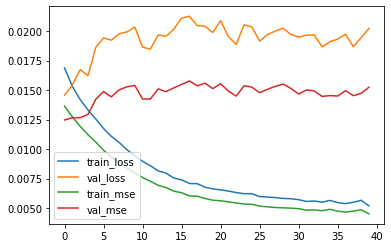

In [112]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mse'], label='train_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.legend()
plt.show()

In [113]:
pred_val = lstm_model.predict(valX)
pred_val.shape

(33663, 63, 1)

In [114]:
pred_val[500, :]

array([[ 0.0032975 ],
       [-0.00339192],
       [-0.00049653],
       [-0.00241695],
       [-0.00399574],
       [-0.00642178],
       [-0.00794114],
       [-0.00528826],
       [-0.00850429],
       [-0.01175578],
       [-0.00874914],
       [-0.00978089],
       [-0.00851565],
       [-0.00750406],
       [-0.00917843],
       [-0.0085857 ],
       [-0.00469763],
       [-0.003045  ],
       [-0.00255439],
       [-0.00554391],
       [-0.01008754],
       [-0.00598433],
       [-0.00612042],
       [-0.00791504],
       [-0.00561443],
       [-0.00193971],
       [-0.00045005],
       [-0.00046248],
       [ 0.00164918],
       [-0.00050949],
       [-0.0002895 ],
       [ 0.00041355],
       [ 0.00314259],
       [ 0.00278338],
       [-0.00055545],
       [ 0.00271835],
       [-0.0014641 ],
       [ 0.00608525],
       [ 0.00836749],
       [ 0.01024688],
       [ 0.00693525],
       [ 0.0110314 ],
       [ 0.01344821],
       [ 0.01232244],
       [ 0.01057573],
       [ 0

In [115]:
trainY[0, 20]

array([0.3230903], dtype=float32)

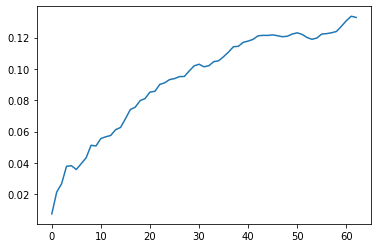

In [116]:
# Correlation plot
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_val[:, i, 0], valY[:, i, 0])[0][1])
plt.plot(c)

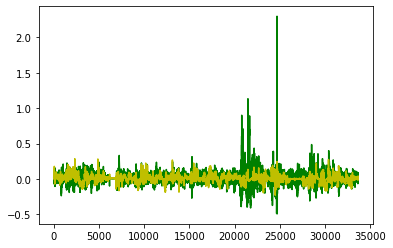

In [117]:
forecast_period = 21
plt.plot(valY[:, forecast_period-1, 0], c="g")
plt.plot(pred_val[:, forecast_period-1, 0], c="y")

In [118]:
stocks[0].index[split1]

Timestamp('2014-03-04 00:00:00')

In [119]:
len(c)

63

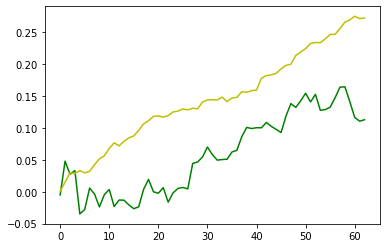

In [120]:
i = 2220
plt.plot(valY[i, : , 0], c="g")
plt.plot(pred_val[i, : , 0], c="y")

In [121]:
pred_train = lstm_model.predict(trainX)

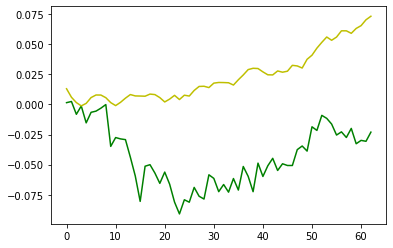

In [122]:
plt.plot(trainY[1000, : , 0], c="g")
plt.plot(pred_train[1000, : , 0], c="y")

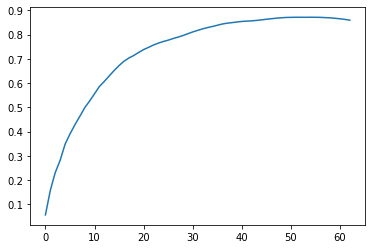

In [123]:
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_train[:, i, 0], trainY[:, i, 0])[0][1])
plt.plot(c)

In [124]:
pred_test = lstm_model.predict(testX)

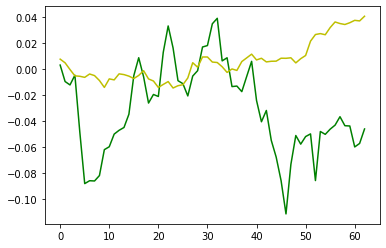

In [125]:
plt.plot(testY[100, : , 0], c="g")
plt.plot(pred_test[100, : , 0], c="y")

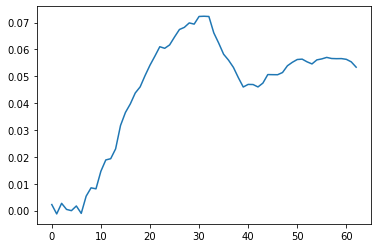

In [126]:
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_test[:, i, 0], testY[:, i, 0])[0][1])
plt.plot(c)

In [127]:
lstm_model.save("WEIGHTS")

INFO:tensorflow:Assets written to: WEIGHTS/assets


INFO:tensorflow:Assets written to: WEIGHTS/assets


In [128]:
import collections

In [144]:
# Portfolio development for top 10, 21 days forecast vs index
rows = len(testStocks_Y[0])
row = 0
cash = 100
cash_list = []
index = 100
index_list = []
stocks_to_buy = 10
forecast_horizon = 21
while row < rows:
    print(row, rows)
    preds = {}
    preds_steps = {}
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += float(index/len(stocks)*outcome)
        #print("f", forecast)
        #print("o", outcome)
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += float(cash/stocks_to_buy*outcome)
            else:
                print("DIDN'T BUY!")
        #if (k>=len(stocks)-stocks_to_buy): # we don't want to short DJIA
        #    if forecast < 0.05:
        #        gains -= float(cash/stocks_to_buy*outcome)
        k+=1
    cash += gains
    cash_list.append(cash)
    index += index_gains
    index_list.append(index)
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

0 594
21 594
42 594
63 594
84 594
105 594
126 594
147 594
168 594
189 594
210 594
231 594
252 594
273 594
294 594
315 594
336 594
357 594
378 594
399 594
420 594
441 594
462 594
483 594
504 594
525 594
546 594
567 594
588 594
AI$ 159.60511855129153
INDEX$ 114.50578955037054


[98.92881830502301, 105.39233682025224, 104.7179710008204, 108.565459061414, 103.00144620612264, 106.08777714893222, 91.53342066332698, 106.34154049679637, 114.27923874184489, 112.74163333605975, 115.43473508488387, 107.99909203778952, 114.2166148154065, 117.9731277814135, 111.00903250556439, 120.5299278749153, 118.93038910906762, 124.97576877754182, 134.89219849463552, 135.57835391815752, 129.61578491237015, 102.44086477067322, 102.40443169977516, 121.03055570926517, 119.12642774824053, 125.70634973887354, 152.5766011038795, 145.86294552031904, 159.60511855129153]
[98.67433521267958, 102.00916342553683, 102.41856543463655, 105.26513443840668, 99.18144696438685, 97.53732130443677, 85.77784681459889, 97.78717373264953, 104.10045304935193, 101.67010109842522, 104.17161704757018, 100.18349886283977, 104.69047220735229, 107.56597931095166, 98.68167028547032, 104.78253773023607, 105.64177151076728, 111.40217362256953, 114.87137928238371, 112.2180047595175, 106.95782104053069, 86.38526509993

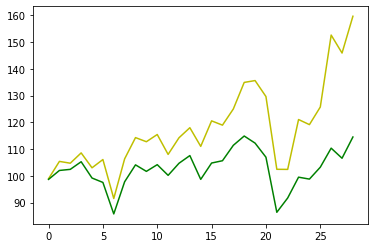

In [145]:
print(cash_list)
print(index_list)
plt.plot(cash_list, c="y")
plt.plot(index_list, c="g")

In [131]:
stocks[0].index[5000]

Timestamp('2018-02-21 00:00:00')

In [132]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               54000     
_________________________________________________________________
dense_2 (Dense)              (None, 63)                6363      
_________________________________________________________________
reshape_2 (Reshape)          (None, 63, 1)             0         
Total params: 60,363
Trainable params: 60,363
Non-trainable params: 0
_________________________________________________________________


In [30]:
#lstm_model = models.load_model("WEIGHTS", compile=False)
#stocks = [pd.read_csv("stocks/AA.csv")]
#stocks[0].set_index("Date", inplace=True)

In [31]:
#stocks[0]

,Adj Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,rd_sale,...,at_turn,pcf,accrual,roa,cash_lt,capital_ratio,lt_debt,debt_invcap,cash_debt,debt_at
Date,,,,,,,,,,,,,,,,,,,,,
1998-04-08,0.013634,19.027073,-0.47,0.66,-0.17,-0.46,-0.17,0.02,0.15,0.011,...,1.004,6.129,0.082,0.167,0.126,0.248,0.202,0.199,0.262,0.149
1998-04-09,0.023977,20.181403,0.79,0.18,-0.07,-0.07,-0.09,0.02,0.19,0.011,...,1.004,6.129,0.082,0.167,0.126,0.248,0.202,0.199,0.262,0.149
1998-04-13,0.016562,21.110806,-0.05,-0.14,0.82,-0.02,-0.13,0.02,0.15,0.011,...,1.004,6.129,0.082,0.167,0.126,0.248,0.202,0.199,0.262,0.149
1998-04-14,0.067416,22.437057,0.71,0.11,0.28,-0.43,-0.25,0.02,0.36,0.011,...,1.004,6.129,0.082,0.167,0.126,0.248,0.202,0.199,0.262,0.149
1998-04-15,0.030526,26.697281,0.40,0.10,-0.11,-0.34,-0.29,0.02,-0.22,0.011,...,1.004,6.129,0.082,0.167,0.126,0.248,0.202,0.199,0.262,0.149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-0.011701,34.843157,0.24,-0.41,-0.33,0.24,0.09,0.00,0.10,0.003,...,0.668,5.987,0.077,0.075,0.131,0.349,0.246,0.274,0.078,0.153
2020-12-28,0.012750,33.600640,0.50,-0.86,0.34,1.05,0.39,0.00,-0.76,0.003,...,0.668,5.987,0.077,0.075,0.131,0.349,0.246,0.274,0.078,0.153
2020-12-29,-0.008993,29.230752,-0.36,-1.17,0.29,0.54,0.12,0.00,-0.41,0.003,...,0.668,5.987,0.077,0.075,0.131,0.349,0.246,0.274,0.078,0.153


(34,)
[ 4  2  1 25 17  8 26 29 30  5 31 10 22  6 15  0 24  3 16 33 23 11 14 21
 13 20 32  7 12 27 19 28 18  9]
HML
Mkt-RF
Volume
at_turn
debt_assets
WML
pcf
cash_lt
capital_ratio
RMW
lt_debt
ps
aftret_equity
CMA
opmad
Adj Close
sale_invcap
SMB
gpm
cash_debt
equity_invcap
npm
opmbd
aftret_eq
GProf
adv_sale
debt_invcap
RF
ptpm
accrual
staff_sale
roa
de_ratio
rd_sale


'Weights'

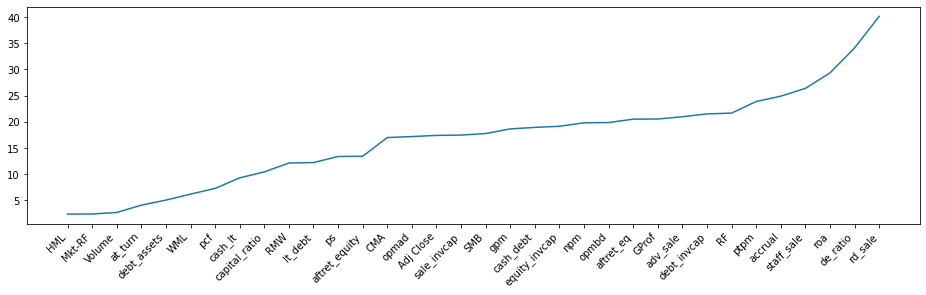

In [35]:
# Bad feature importance
w = np.array(lstm_model.layers[0].get_weights()[0])
wi = w[:, :100] # number of units
inputs = abs(wi.sum(axis=1))
print(inputs.shape)
# ascending order
print(inputs.argsort())
for i in inputs.argsort():
    print(stocks[0].columns[i])
f, ax = plt.subplots(figsize=(16, 4))
ax.plot(inputs[inputs.argsort()])
ax.set_xticks(range(34))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(stocks[0].columns[inputs.argsort()])
"Weights"

(34,)
[17 25  0 29 16 23 31 24 22 13 21 12 14 10 33 20 27 15  9 11 28  7 30  1
  3 32  2  5  4 18 26  8 19  6]
debt_assets
at_turn
Adj Close
cash_lt
gpm
equity_invcap
lt_debt
sale_invcap
aftret_equity
GProf
aftret_eq
ptpm
opmbd
ps
cash_debt
adv_sale
accrual
opmad
rd_sale
npm
roa
RF
capital_ratio
Volume
SMB
debt_invcap
Mkt-RF
RMW
HML
de_ratio
pcf
WML
staff_sale
CMA


'Weights'

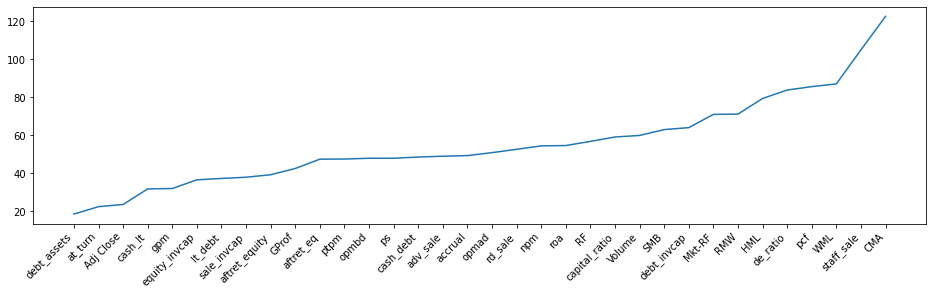

In [156]:
# Good feature importance
w = np.array(lstm_model.layers[0].get_weights()[0])
wi = abs(w[:, :100]) # number of units
inputs = wi.sum(axis=1)
print(inputs.shape)
# ascending order
print(inputs.argsort())
for i in inputs.argsort():
    print(stocks[0].columns[i])
f, ax = plt.subplots(figsize=(16, 4))
ax.plot(inputs[inputs.argsort()])
ax.set_xticks(range(34))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(stocks[0].columns[inputs.argsort()])
"Weights"

(34, 100)
[32 18 11 10  6 28 21  4 26  6  4  6 26 18  7  9 19  6  6  6  5  6  6  9
 23  6  1  6  6 30 25  6  6  2 19 19 26  6 19 18 19  4 11  8  5  6  6 18
 32 19  6  4 18 25  8 21 17 19  8 26  1  6  8  8  6  6  0  4 19  5  4  5
 18 30 18  8 26 12  2  4  0  2 26  8 19 15 19 19  6  3  4  6  5  4 19  7
 32  0  6  2]
(100,)


'Ratio per max'

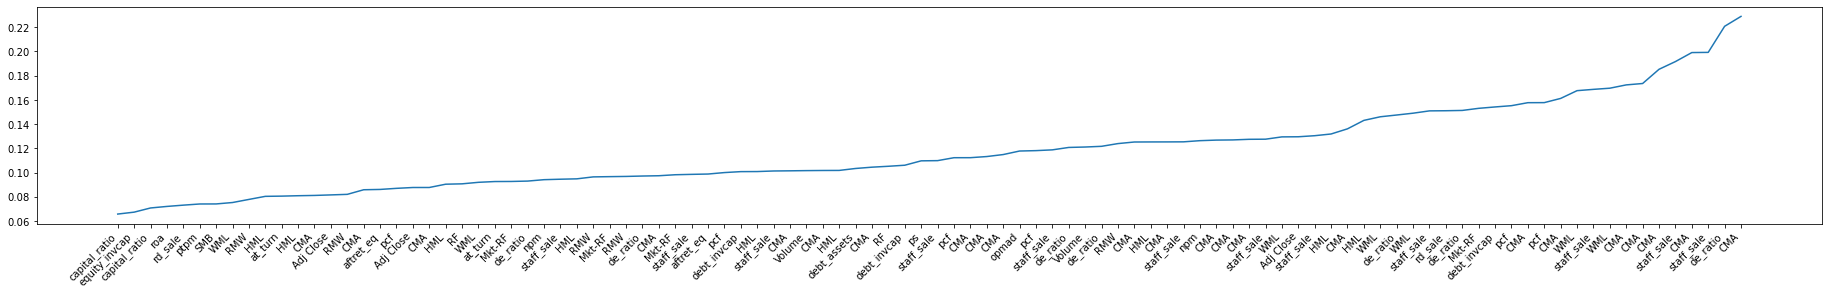

In [157]:
# Really complicated feature importance

def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)

w = np.array(lstm_model.layers[0].get_weights()[0])
units = 100
wi = abs(w[:, :units]) # number of units
print(wi.shape)

a = np.zeros(100)

inputs = wi.argmax(axis=0)

print(inputs)
print(inputs.shape)

for i in range(100):
    a[i] = wi[inputs[i], i]/sum(abs(wi[: , i]))

f, ax = plt.subplots(figsize=(32, 4))
ax.plot(np.sort(a))
ax.set_xticks(range(100))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(stocks[0].columns[inputs[a.argsort()]])
"Ratio per max"

[0.06570287 0.06727959 0.07073155 0.07199968 0.07306141 0.07401572
 0.07405751 0.07522429 0.07778832 0.0803245  0.08050527 0.08084004
 0.08107671 0.08151282 0.08197198 0.08577069 0.08602975 0.08692849
 0.08762531 0.08763489 0.09034685 0.09065337 0.09190325 0.09254684
 0.0926134  0.09292539 0.09408451 0.09446487 0.09477744 0.09638457
 0.09658695 0.09676616 0.09709253 0.09733623 0.0981583  0.0984719
 0.09873987 0.09994606 0.1007289  0.10078964 0.10125894 0.10139492
 0.10156423 0.10167449 0.1017274  0.10333106 0.10440324 0.10514674
 0.106014   0.10963266 0.10980062 0.11221636 0.11223733 0.11317691
 0.11481218 0.11773157 0.11805922 0.11869903 0.12069123 0.12103684
 0.12162025 0.12387212 0.12517916 0.12523171 0.12525915 0.12532003
 0.12627868 0.12675228 0.12689504 0.12740833 0.12750428 0.12940609
 0.12950468 0.13038173 0.1317985  0.13605462 0.14303196 0.14600159
 0.14745996 0.14896234 0.15087562 0.15099368 0.15123929 0.15297442
 0.15411516 0.15516465 0.1576303  0.1576876  0.16115528 0.16755

'Ratio per max'

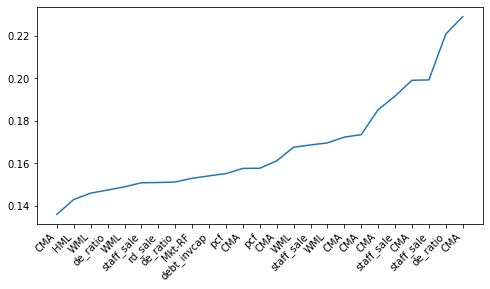

In [158]:
b = np.sort(a)
c = stocks[0].columns[inputs[a.argsort()]]

print(b)
print(c)

b = b[75:]
c = c[75:]

f, ax = plt.subplots(figsize=(8, 4))
ax.plot(b)
ax.set_xticks(range(25))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(c)
"Ratio per max"

In [142]:
rows = len(testStocks_Y[0])
row = 0
cash = 100
cash_list = []
index = 100
index_list = []
stocks_to_buy = 10
forecast_horizon = 51
while row < rows:
    print(row, rows)
    preds = {}
    preds_steps = {}
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += float(index/len(stocks)*outcome)
        #print("f", forecast)
        #print("o", outcome)
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += float(cash/stocks_to_buy*outcome)
            else:
                print("DIDN'T BUY!")
        #if (k>=len(stocks)-stocks_to_buy): # we don't want to short DJIA
        #    if forecast < 0.05:
        #        gains -= float(cash/stocks_to_buy*outcome)
        k+=1
    cash += gains
    cash_list.append(cash)
    index += index_gains
    index_list.append(index)
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

0 594
51 594
102 594
153 594
204 594
255 594
306 594
357 594
408 594
459 594
510 594
561 594
AI$ 127.16974136419594
INDEX$ 106.81250551986159


[99.15246704593301, 99.01827994734049, 86.37260307371616, 102.68695430457592, 91.61876632273197, 98.07230809517205, 105.82526572234929, 118.70496627874672, 77.3598783928901, 119.5988462138921, 141.79090590961277, 127.16974136419594]
[102.74661249457859, 99.84485037717968, 89.24215549370274, 102.39822722552344, 96.95945664442843, 100.46857511781855, 104.46832661115332, 113.10780978194089, 71.23338308176608, 103.25958811482997, 110.35534484489472, 106.81250551986159]


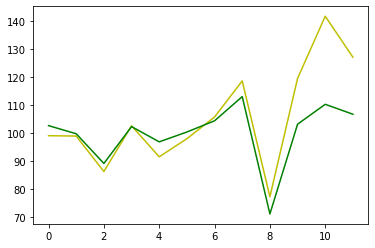

In [143]:
print(cash_list)
print(index_list)
plt.plot(cash_list, c="y")
plt.plot(index_list, c="g")

In [136]:
rows = len(testStocks_Y[0])
row = 0
cash = 100
cash_list = []
index = 100
index_list = []
stocks_to_buy = 10
forecast_horizon = 12
while row < rows:
    print(row, rows)
    preds = {}
    preds_steps = {}
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += float(index/len(stocks)*outcome)
        #print("f", forecast)
        #print("o", outcome)
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += float(cash/stocks_to_buy*outcome)
            else:
                print("DIDN'T BUY!")
        #if (k>=len(stocks)-stocks_to_buy): # we don't want to short DJIA
        #    if forecast < 0.05:
        #        gains -= float(cash/stocks_to_buy*outcome)
        k+=1
    cash += gains
    cash_list.append(cash)
    index += index_gains
    index_list.append(index)
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

0 594
12 594
24 594
36 594
48 594
60 594
72 594
84 594
96 594
108 594
120 594
132 594
144 594
156 594
168 594
180 594
192 594
204 594
216 594
228 594
240 594
252 594
264 594
276 594
288 594
300 594
312 594
324 594
336 594
348 594
360 594
372 594
384 594
396 594
408 594
420 594
432 594
444 594
456 594
468 594
480 594
492 594
504 594
516 594
528 594
540 594
552 594
564 594
576 594
588 594
AI$ 229.61918295104988
INDEX$ 124.36505443496571


[101.66281574778259, 96.97213198058307, 100.89206863753498, 101.28431831859052, 102.35021933726966, 102.97800648305565, 105.84954978059977, 102.4209361076355, 99.53515529003926, 109.36299925413914, 110.37365827080794, 97.88241550442763, 101.5406614553649, 104.77018906665035, 109.16726264101453, 112.49509216588922, 111.22107624378987, 113.35436935839243, 113.8101410951931, 108.39427700010128, 105.7049046207685, 109.22844437253661, 113.3680124853272, 114.66484220814891, 106.12125655007549, 109.11721932631917, 115.82884951052256, 116.73317553964444, 113.35357701149769, 119.00853258860298, 121.58542243135162, 123.28514347714372, 132.29286572081037, 132.14220499736257, 134.49129062634893, 140.2067165572662, 128.02746905875392, 89.50723033142276, 95.72641994268633, 110.72597080678679, 126.70829884917475, 135.25778763671406, 133.3403763838578, 127.35974369128235, 130.8885263868142, 204.62647608597763, 200.88116543670185, 204.9321302094031, 209.36804819782265, 229.61918295104988]
[102.13617026

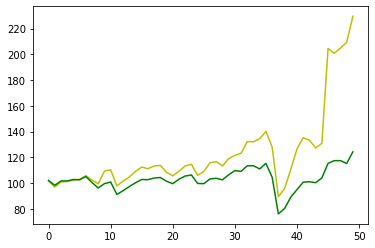

In [137]:
print(cash_list)
print(index_list)
plt.plot(cash_list, c="y")
plt.plot(index_list, c="g")

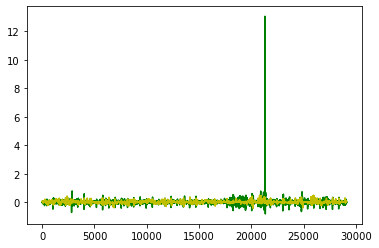

In [138]:
forecast_period = 21
plt.plot(testY[:, forecast_period-1, 0], c="g")
plt.plot(pred_test[:, forecast_period-1, 0], c="y")

In [139]:
for i in range(len(testStocks_Y)):
    stock = testStocks_Y[i]
    print(i, max(stock[:,0]))

0 [0.12598641]
1 [0.2188226]
2 [0.10897722]
3 [0.11980826]
4 [0.24318606]
5 [0.10332067]
6 [0.22740704]
7 [0.13373496]
8 [0.06479572]
9 [0.2090909]
10 [0.17580317]
11 [0.1375085]
12 [0.15068367]
13 [0.11301056]
14 [0.19521281]
15 [0.0799773]
16 [0.18012485]
17 [0.18125457]
18 [0.07783631]
19 [0.14216886]
20 [0.15175152]
21 [0.12009031]
22 [0.260449]
23 [0.13290232]
24 [0.12798929]
25 [0.07208645]
26 [0.13842657]
27 [0.12603606]
28 [0.11708502]
29 [0.14412314]
30 [0.5213959]
31 [0.17303658]
32 [0.26369855]
33 [0.12832554]
34 [0.10022344]
35 [3.1813602]
36 [0.16841367]
37 [0.1002197]
38 [0.18808313]
39 [0.1798428]
40 [0.11280707]
41 [0.28218693]
42 [0.1779621]
43 [0.16645011]
44 [0.14176233]
45 [0.14729951]
46 [0.1575717]
47 [0.12686796]
48 [0.08960691]


In [140]:
print(tickers[35])

KODK


(-1.0, 2.0)

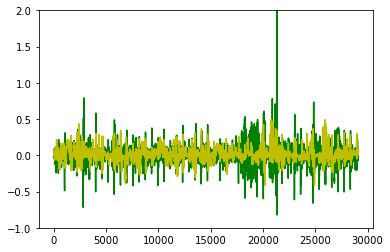

In [141]:
forecast_period = 21
plt.plot(testY[:, forecast_period-1, 0], c="g")
plt.plot(pred_test[:, forecast_period-1, 0], c="y")
axes = plt.gca()
axes.set_ylim([-1,2])

In [147]:
rows = len(testStocks_Y[0])
row = 0
cash = 100
cash_list = []
index = 100
index_list = []
stocks_to_buy = 10
forecast_horizon = 1
while row < rows:
    #print(row, rows)
    preds = {}
    preds_steps = {}
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += float(index/len(stocks)*outcome)
        #print("f", forecast)
        #print("o", outcome)
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += float(cash/stocks_to_buy*outcome)
            else:
                print("DIDN'T BUY!")
        #if (k>=len(stocks)-stocks_to_buy): # we don't want to short DJIA
        #    if forecast < 0.05:
        #        gains -= float(cash/stocks_to_buy*outcome)
        k+=1
    cash += gains
    cash_list.append(cash)
    index += index_gains
    index_list.append(index)
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

AI$ 133.18798571897787
INDEX$ 116.21346016198373


[99.22467980952933, 97.20261420542374, 99.1112857782282, 98.21737262245733, 99.51351903483737, 100.4129008530872, 100.33980135817546, 102.01834819384385, 101.48345511371735, 101.59587464819197, 102.17584438773338, 102.01886854751501, 100.98788973409683, 100.5374130262062, 100.7530273636803, 100.28921761456877, 98.32789946626872, 98.46756692789495, 97.55973109602928, 98.29635620862246, 96.81677233520895, 97.14464890491217, 96.66672222968191, 96.96141114085913, 97.2306778440252, 97.28004728257656, 97.11147295963019, 97.9609798702877, 98.44547389703803, 99.22682650270872, 100.06438075820915, 99.20604855078273, 100.06754991831258, 100.27724958816543, 99.50717698782682, 100.00756314210594, 99.97465488035232, 99.90954334544949, 99.83665304002352, 99.69649695162661, 100.407114937203, 101.4733487025369, 101.88945000735112, 101.3249375873711, 100.63171859667636, 102.20519979042001, 100.1579811994452, 100.16681304504164, 100.64335058932193, 100.88264817069285, 101.33337067230605, 101.24078434496

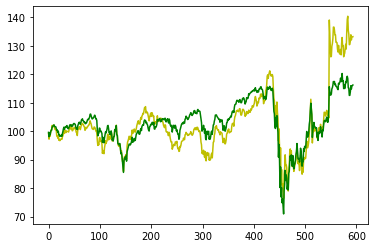

In [148]:
print(cash_list)
print(index_list)
plt.plot(cash_list, c="y")
plt.plot(index_list, c="g")

In [155]:
rows = len(testStocks_Y[0])
row = 0
cash = 100
cash_list = []
index = 100
index_list = []
stocks_to_buy = len(stocks)
forecast_horizon = 21
while row < rows:
    print(row, rows)
    preds = {}
    preds_steps = {}
    positive = 0
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
        if pred > 0:
            positive += 1
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += float(index/len(stocks)*outcome)
        #print("f", forecast)
        #print("o", outcome)
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += float(cash/min(stocks_to_buy, positive)*outcome)
            else:
                print("DIDN'T BUY!")
        #if (k>=len(stocks)-stocks_to_buy): # we don't want to short DJIA
        #    if forecast < 0.05:
        #        gains -= float(cash/stocks_to_buy*outcome)
        k+=1
    cash += gains
    cash_list.append(cash)
    index += index_gains
    index_list.append(index)
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

0 594
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
21 594
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
42 594
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
63 594
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
DIDN'T BUY!
D

[98.43315358064137, 101.37578341900371, 100.95560868061148, 104.12048200913705, 101.13144966424443, 101.77169203967787, 89.45788647071458, 101.25606843014248, 107.24726769689005, 105.6622374918079, 106.77516578545328, 102.07218974304851, 106.60979282122571, 109.37538716534618, 99.49541347532067, 106.40031434979755, 106.5795457988279, 112.51240378443617, 117.06513426371384, 115.41809051402379, 108.30888495000545, 88.26836706476752, 90.44006050156895, 105.26873687433545, 104.04274176026229, 109.78553468326572, 127.74779483827297, 126.42922639253084, 133.56752394570503]
[98.67433521267958, 102.00916342553683, 102.41856543463655, 105.26513443840668, 99.18144696438685, 97.53732130443677, 85.77784681459889, 97.78717373264953, 104.10045304935193, 101.67010109842522, 104.17161704757018, 100.18349886283977, 104.69047220735229, 107.56597931095166, 98.68167028547032, 104.78253773023607, 105.64177151076728, 111.40217362256953, 114.87137928238371, 112.2180047595175, 106.95782104053069, 86.385265099

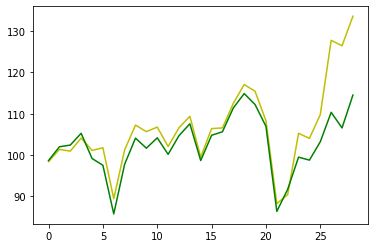

In [161]:
print(cash_list)
print(index_list)
plt.plot(cash_list, c="y")
plt.plot(index_list, c="g")

In [154]:
# save testStocks so you can run tests later if needed
for i in range(len(testStocks_X)):
    X = testStocks_X[i]
    Y = testStocks_Y[i]
    np.save("testStocks/" + str(i) + "_X.pkl", X)
    np.save("testStocks/" + str(i) + "_Y.pkl", Y)

In [163]:
for i in range(len(stocks)):
    stock = stocks[i]
    ticker = tickers[i]
    stock.to_csv("stocks/" + ticker + ".csv")